# Functions for downloading files over the internet

In [5]:
import sys
import os
import urllib
import tarfile

def _print_download_progress(count, block_size, total_size):
    """
    Function used for printing the download progress.
    Used as a call-back function in maybe_download_and_extract().
    """

    # Percentage completion.
    pct_complete = float(count * block_size) / total_size

    # Status-message. Note the \r which means the line should overwrite itself.
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()
    
def one_hot_encoded(class_numbers, num_classes=None):
    """
    Generate the One-Hot encoded class-labels from an array of integers.
    For example, if class_number=2 and num_classes=4 then
    the one-hot encoded label is the float array: [0. 0. 1. 0.]
    :param class_numbers:
        Array of integers with class-numbers.
        Assume the integers are from zero to num_classes-1 inclusive.
    :param num_classes:
        Number of classes. If None then use max(cls)-1.
    :return:
        2-dim array of shape: [len(cls), num_classes]
    """

    # Find the number of classes if None is provided.
    if num_classes is None:
        num_classes = np.max(class_numbers) - 1

    return np.eye(num_classes, dtype=float)[class_numbers]

def maybe_download_and_extract(url, download_dir):
    """
    Download and extract the data if it doesn't already exist.
    Assumes the url is a tar-ball file.
    :param url:
        Internet URL for the tar-file to download.
        Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    :param download_dir:
        Directory where the downloaded file is saved.
        Example: "data/CIFAR-10/"
    :return:
        Nothing.
    """

    # Filename for saving the file downloaded from the internet.
    # Use the filename from the URL and add it to the download_dir.
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        file_path, _ = urllib.urlretrieve(url=url,
                                                  filename=file_path,
                                                  reporthook=_print_download_progress)

        print()
        print("Download finished. Extracting files.")

        # Unpack the tar-ball.
        tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")


# Functions for downloading CIFAR10

In [6]:
import numpy as np
import pickle
import os

data_path = "data/CIFAR-10/"

# URL for the data-set on the internet.
data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

# Various constants for the size of the images.

# Width and height of each image.
img_size = 32

# Number of channels in each image, 3 channels: Red, Green, Blue.
num_channels = 3

# Length of an image when flattened to a 1-dim array.
img_size_flat = img_size * img_size * num_channels

# Number of classes.
num_classes = 10

# Number of files for the training-set.
_num_files_train = 5

# Number of images for each batch-file in the training-set.
_images_per_file = 10000

# Total number of images in the training-set.
# This is used to pre-allocate arrays for efficiency.
_num_images_train = _num_files_train * _images_per_file

# Private functions for downloading, unpacking and loading data-files.
def _get_file_path(filename=""):
    """
    Return the full path of a data-file for the data-set.
    If filename=="" then return the directory of the files.
    """

    return os.path.join(data_path, "cifar-10-batches-py/", filename)


def _unpickle(filename):
    """
    Unpickle the given file and return the data.
    Note that the appropriate dir-name is prepended the filename.
    """

    # Create full path for the file.
    file_path = _get_file_path(filename)

    print("Loading data: " + file_path)

    with open(file_path, mode='rb') as file:
        # In Python 3.X it is important to set the encoding,
        # otherwise an exception is raised here.
        data = pickle.load(file)

    return data


def _convert_images(raw):
    """
    Convert images from the CIFAR-10 format and
    return a 4-dim array with shape: [image_number, height, width, channel]
    where the pixels are floats between 0.0 and 1.0.
    """

    # Convert the raw images from the data-files to floating-points.
    raw_float = np.array(raw, dtype=float) / 255.0

    # Reshape the array to 4-dimensions.
    images = raw_float.reshape([-1, num_channels, img_size, img_size])

    # Reorder the indices of the array.
    images = images.transpose([0, 2, 3, 1])

    return images


def _load_data(filename):
    """
    Load a pickled data-file from the CIFAR-10 data-set
    and return the converted images (see above) and the class-number
    for each image.
    """

    # Load the pickled data-file.
    data = _unpickle(filename)

    # Get the raw images.
    raw_images = data[b'data']

    # Get the class-numbers for each image. Convert to numpy-array.
    cls = np.array(data[b'labels'])

    # Convert the images.
    images = _convert_images(raw_images)

    return images, cls

# Public functions that you may call to download the data-set from
# the internet and load the data into memory.
def load_class_names():
    """
    Load the names for the classes in the CIFAR-10 data-set.
    Returns a list with the names. Example: names[3] is the name
    associated with class-number 3.
    """

    # Load the class-names from the pickled file.
    raw = _unpickle(filename="batches.meta")[b'label_names']

    # Convert from binary strings.
    names = [x.decode('utf-8') for x in raw]

    return names


def load_training_data():
    """
    Load all the training-data for the CIFAR-10 data-set.
    The data-set is split into 5 data-files which are merged here.
    Returns the images, class-numbers and one-hot encoded class-labels.
    """

    # Pre-allocate the arrays for the images and class-numbers for efficiency.
    images = np.zeros(shape=[_num_images_train, img_size, img_size, num_channels], dtype=float)
    cls = np.zeros(shape=[_num_images_train], dtype=int)

    # Begin-index for the current batch.
    begin = 0

    # For each data-file.
    for i in range(_num_files_train):
        # Load the images and class-numbers from the data-file.
        images_batch, cls_batch = _load_data(filename="data_batch_" + str(i + 1))

        # Number of images in this batch.
        num_images = len(images_batch)

        # End-index for the current batch.
        end = begin + num_images

        # Store the images into the array.
        images[begin:end, :] = images_batch

        # Store the class-numbers into the array.
        cls[begin:end] = cls_batch

        # The begin-index for the next batch is the current end-index.
        begin = end

    return images, cls, one_hot_encoded(class_numbers=cls, num_classes=num_classes)


def load_test_data():
    """
    Load all the test-data for the CIFAR-10 data-set.
    Returns the images, class-numbers and one-hot encoded class-labels.
    """

    images, cls = _load_data(filename="test_batch")

    return images, cls, one_hot_encoded(class_numbers=cls, num_classes=num_classes)


In [7]:
maybe_download_and_extract(url=data_url, download_dir=data_path)

Data has apparently already been downloaded and unpacked.


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import math
import os

# Use PrettyTensor to simplify Neural Network construction.
import prettytensor as pt

In [55]:
load_class_names()

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


[u'airplane',
 u'automobile',
 u'bird',
 u'cat',
 u'deer',
 u'dog',
 u'frog',
 u'horse',
 u'ship',
 u'truck']

In [11]:
images_train, cls_train, labels_train = load_training_data()
images_test, cls_test, labels_test = load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


In [57]:
print "Size of:" 
print "- Training-set: ", len(images_train)
print "- Test-set:     ", len(images_test)

Size of:
- Training-set:  50000
- Test-set:      10000


In [14]:
# Using a smaller cropped image for this example. 
img_size_cropped = 24

In [15]:
# Helper function to plot the images to see what they are
# Inputs: image
def plot_images(images, cls_true, cls_pred=None, smooth=True):
    assert len(images) == len(cls_true) == 9
    fig, axes = plt.subplots(3, 3)
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
        cls_true_name = class_names[cls_true[i]]
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            cls_pred_name = class_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)
        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])    
    plt.show()

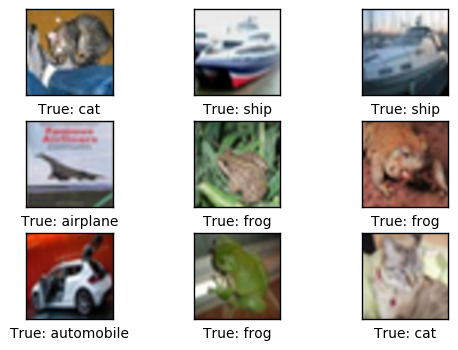

In [16]:
# Get the first images from the test-set.
images = images_test[0:9]

# Get the true classes for those images.
cls_true = cls_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

In [17]:
x = tf.placeholder(
    tf.float32, 
    shape=[None, img_size, img_size, num_channels], 
    name='x')

y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

y_true_cls = tf.argmax(y_true, dimension=1)

In [18]:
def pre_process_image(image, training):
    if training:
        # For training, add the following to the TensorFlow graph.
        # Randomly crop the input image.
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])
        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)        
        # Randomly adjust hue, contrast and saturation.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)
        # Limit the image pixels between [0, 1] in case of overflow.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        # For training, add the following to the TensorFlow graph.
        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image

In [19]:
def pre_process(images, training):
    # Use TensorFlow to loop over all the input images and call
    # the function above which takes a single image as input.
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)

    return images

In [20]:
distorted_images = pre_process(images=x, training=True)

In [21]:
def lenet5_network(images, training):
    # Wrap the input images as a Pretty Tensor object.
    x_pretty = pt.wrap(images)

    # Pretty Tensor uses special numbers to distinguish between
    # the training and testing phases.
    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer

    # Create the convolutional neural network using Pretty Tensor.
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=6, name='layer_conv1', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=16, name='layer_conv2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=120, name='layer_fc1').\
            fully_connected(size=84, name='layer_fc2').\
            softmax_classifier(class_count=num_classes, labels=y_true)

    return y_pred, loss

In [22]:
def create_network(training):
    # Wrap the neural network in the scope named 'network'.
    # Create new variables during training, and re-use during testing.
    with tf.variable_scope('network', reuse=not training):
        images = x
        images = pre_process(images=images, training=training)
        y_pred, loss = lenet5_network(images=images, training=training)
    return y_pred, loss

In [23]:
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

In [24]:
_, loss = create_network(training=True)

In [25]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)

In [26]:
y_pred, _ = create_network(training=False)
y_pred_cls = tf.argmax(y_pred, dimension=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [27]:
saver = tf.train.Saver()

In [28]:
def get_weights_variable(layer_name):
    with tf.variable_scope("network/" + layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

In [29]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')

In [30]:
def get_layer_output(layer_name):
    tensor_name = "network/" + layer_name + "/Relu:0"
    tensor = tf.get_default_graph().get_tensor_by_name(tensor_name)

    return tensor

In [31]:
output_conv1 = get_layer_output(layer_name='layer_conv1')
output_conv2 = get_layer_output(layer_name='layer_conv2')

In [32]:
session = tf.Session()

In [33]:
save_dir = 'checkpoints/'

In [34]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [35]:
save_path = save_dir + 'cifar10_cnn'

In [36]:
try:
    print("Trying to restore last checkpoint ...")
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)
    saver.restore(session, save_path=last_chk_path)
    print("Restored checkpoint from:", last_chk_path)
except:
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.initialize_all_variables())

Trying to restore last checkpoint ...
('Restored checkpoint from:', u'checkpoints/cifar10_cnn-68500')


In [37]:
train_batch_size = 64

In [38]:
def random_batch():
    # Number of images in the training-set.
    num_images = len(images_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

In [39]:
def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):
        x_batch, y_true_batch = random_batch()
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))
        if (i_global % 1000 == 0) or (i == num_iterations - 1):
            saver.save(session,
                       save_path=save_path,
                       global_step=global_step)

            print("Saved checkpoint.")
    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [40]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    images = images_test[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = cls_test[incorrect]
    
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [41]:
batch_size = 256

def predict_cls(images, labels, cls_true):
    num_images = len(images)
    cls_pred = np.zeros(shape=num_images, dtype=np.int)
    i = 0

    while i < num_images:
        j = min(i + batch_size, num_images)
        feed_dict = {x: images[i:j, :],
                     y_true: labels[i:j, :]}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j
    correct = (cls_true == cls_pred)

    return correct, cls_pred

def predict_cls_test():
    return predict_cls(images = images_test,
                       labels = labels_test,
                       cls_true = cls_test)

In [43]:
def classification_accuracy(correct):
    return correct.mean(), correct.sum()

In [44]:
def print_test_accuracy(show_example_errors=False):
    correct, cls_pred = predict_cls_test()
    acc, num_correct = classification_accuracy(correct)
    num_images = len(correct)
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

In [47]:
def plot_distorted_image(image, cls_true):
    image_duplicates = np.repeat(image[np.newaxis, :, :, :], 9, axis=0)
    feed_dict = {x: image_duplicates}
    result = session.run(distorted_images, feed_dict=feed_dict)
    plot_images(images=result, cls_true=np.repeat(cls_true, 9))

In [48]:
def get_test_image(i):
    return images_test[i, :, :, :], cls_test[i]

In [54]:
img, cls = get_test_image(16)

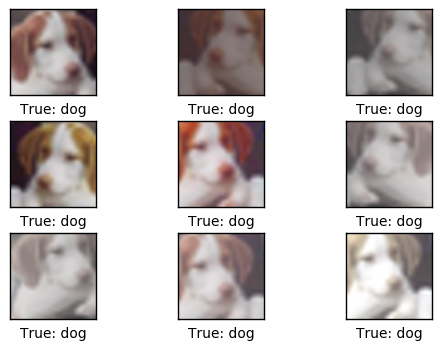

In [50]:
plot_distorted_image(img, cls)

In [60]:
optimize(num_iterations=10000)

Global Step:  88600, Training Batch Accuracy:  62.5%
Global Step:  88700, Training Batch Accuracy:  64.1%
Global Step:  88800, Training Batch Accuracy:  46.9%
Global Step:  88900, Training Batch Accuracy:  59.4%
Global Step:  89000, Training Batch Accuracy:  68.8%
Saved checkpoint.
Global Step:  89100, Training Batch Accuracy:  54.7%
Global Step:  89200, Training Batch Accuracy:  62.5%
Global Step:  89300, Training Batch Accuracy:  67.2%
Global Step:  89400, Training Batch Accuracy:  68.8%
Global Step:  89500, Training Batch Accuracy:  59.4%
Global Step:  89600, Training Batch Accuracy:  62.5%
Global Step:  89700, Training Batch Accuracy:  64.1%
Global Step:  89800, Training Batch Accuracy:  62.5%
Global Step:  89900, Training Batch Accuracy:  54.7%
Global Step:  90000, Training Batch Accuracy:  60.9%
Saved checkpoint.
Global Step:  90100, Training Batch Accuracy:  56.2%
Global Step:  90200, Training Batch Accuracy:  60.9%
Global Step:  90300, Training Batch Accuracy:  68.8%
Global Ste

Accuracy on Test-Set: 62.8% (6282 / 10000)
Example errors:


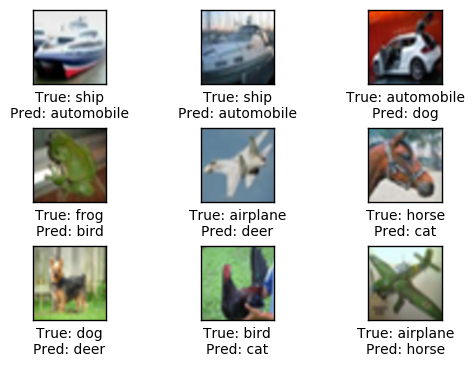

In [61]:
print_test_accuracy(show_example_errors=True)

In [51]:
# session.close()